In [1]:
import pandas as pd
import numpy as np
import sklearn as skl
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
import umap

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import *

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

warnings.filterwarnings("ignore")
%matplotlib inline

# EDA

In [2]:
#получение данных из источника, проверка и переименование полей, исключение заведомо бесполезных для моделирования

data = pd.read_csv('/home/dataengineer/OTUS_ML/OTUS_ML_notebooks/data/datasets_531_1056_german_credit_data.csv')

data = data.drop(['Unnamed: 0'], axis=1)

data.columns =['Age', 'Sex', 'Job', 'Housing', 'Saving_accounts', 'Checking_account', 'Credit_amount', 'Duration', 'Purpose']

data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving_accounts   817 non-null    object
 5   Checking_account  606 non-null    object
 6   Credit_amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
dtypes: int64(4), object(5)
memory usage: 70.4+ KB


,Age,Sex,Job,Housing,Saving_accounts,Checking_account,Credit_amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


In [3]:
#получение базовых статистик

data.describe()

,Age,Job,Credit_amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


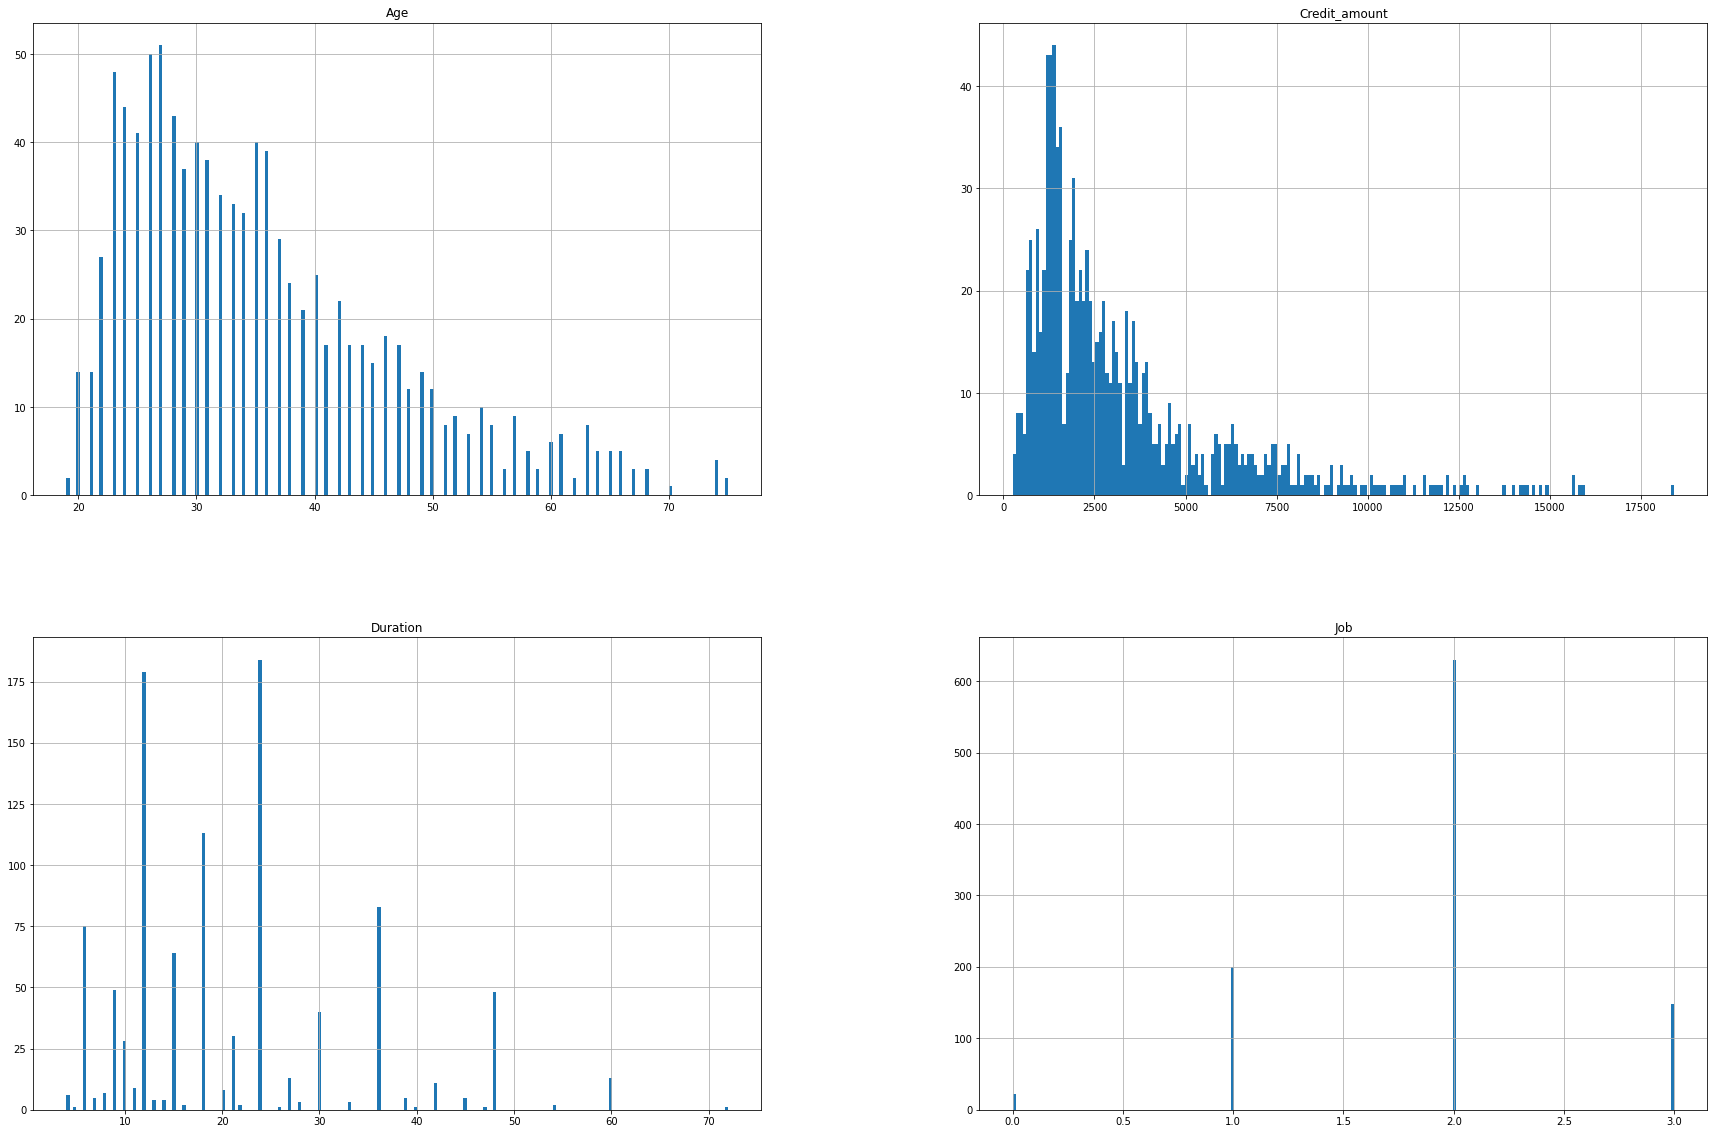

In [4]:
#построение гистограмм для оценки распределения непрерывных переменных

data.hist(figsize=(30, 20), bins=200);

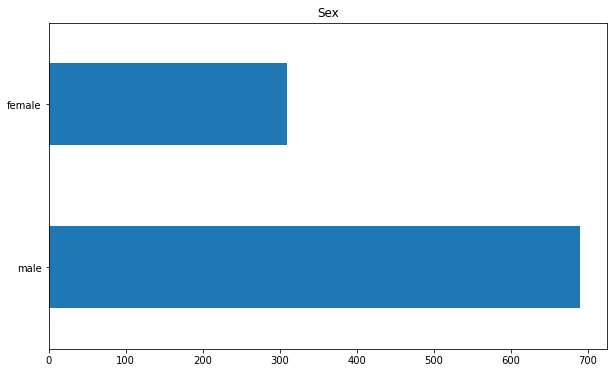

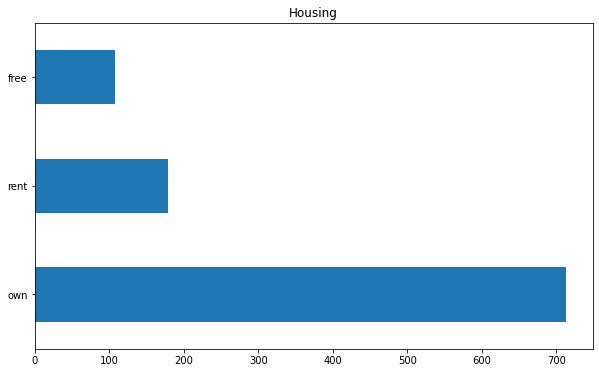

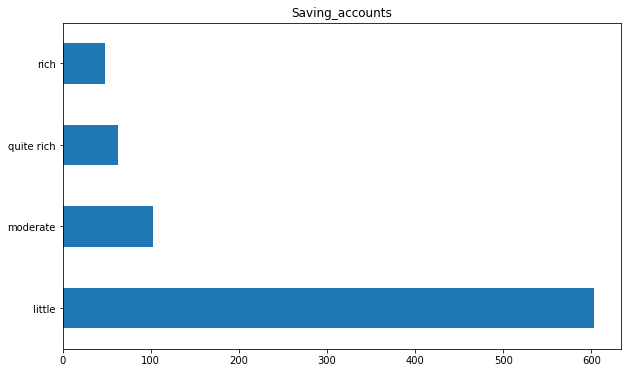

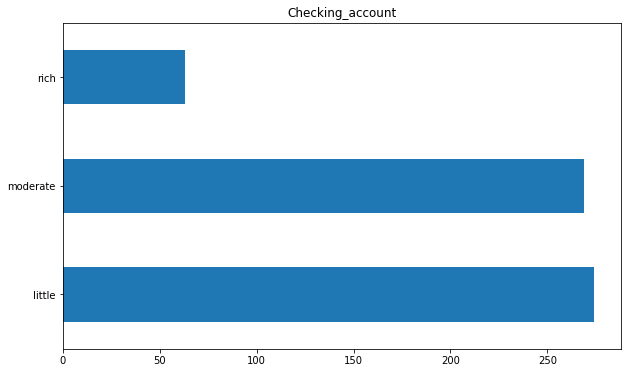

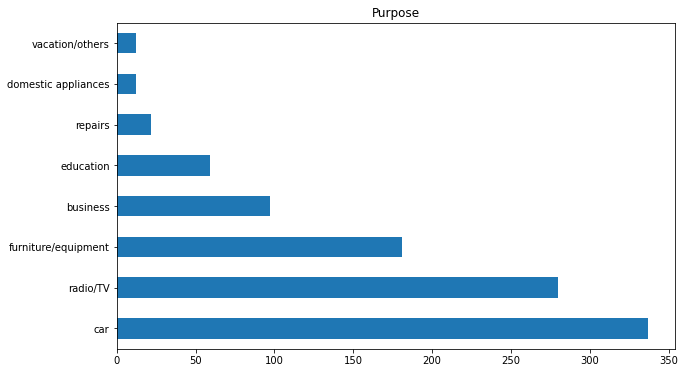

In [5]:
#построение гистограмм для категрориальных переменных

fields_list = list(data)


for i in fields_list:
    
    if data[i].dtype =='object':
        
        data_plot = data[i].value_counts()
        data_plot.plot(kind='barh', figsize=(10, 6), title=i)
        plt.show()  

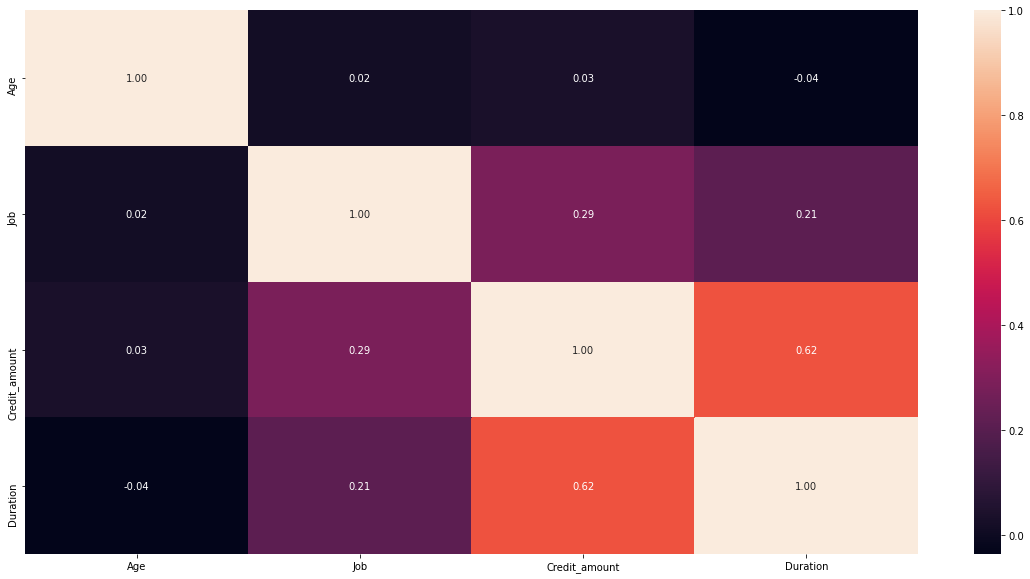

In [6]:
#построение heatmap для оценки корреляции признаков

Corr = data.corr()
plt.figure(figsize=(20,10));
sns.heatmap(Corr, annot=True, fmt='.2f');

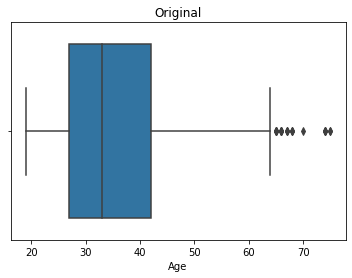

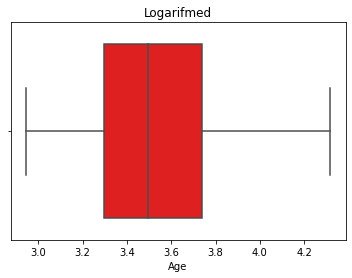

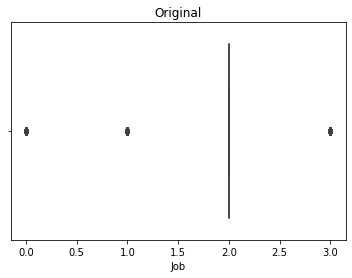

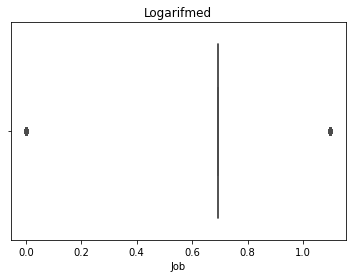

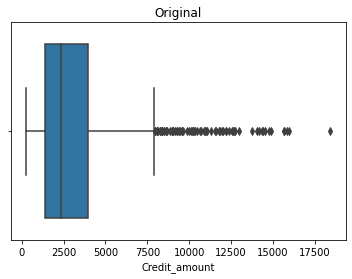

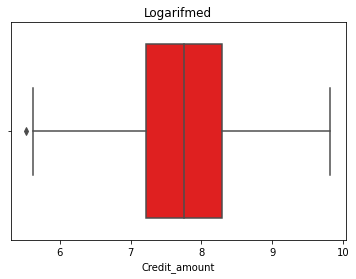

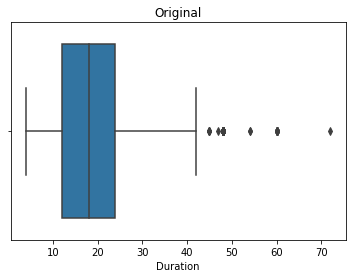

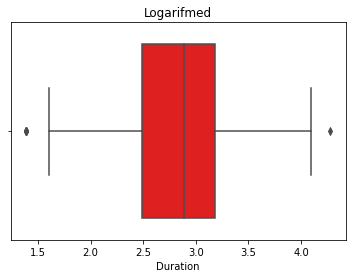

In [7]:
#построение boxplot для каждого признака для оценки распределения - исходные и логарифмированные значения

fields_list = list(data)


for i in fields_list:
    
    if data[i].dtype !='object':
        
        sns.boxplot(data=data[[i]], x = i, orient = "h").set_title("Original")
        plt.show()
        
        data_log = np.log(data[[i]])
        sns.boxplot(data = data_log, x = i, orient = "h", color = 'red').set_title("Logarifmed")
        plt.show()        

# Preprocessing & Feature Engineering

In [8]:
#one-hot кодирование категориальных переменных

data = pd.get_dummies(data, columns=['Job', 'Sex', 'Housing', 'Saving_accounts', 'Checking_account'])

In [9]:
#кодирование кодирование категориальных LabelEncoder

labelencoder = LabelEncoder()

data['Purpose_encoded'] = labelencoder.fit_transform(data['Purpose'])

data.drop(['Purpose'], axis=1, inplace=True)

In [10]:
#логарифмирование непрерывных переменных

data['Age_log'] = np.log(data['Age'])
data['Credit_amount_log'] = np.log(data['Credit_amount'])
data['Duration_log'] = np.log(data['Duration'])

data.drop(['Age', 'Credit_amount', 'Duration'], axis=1, inplace=True)

In [11]:
#стандартизация

data_sc = StandardScaler().fit_transform(data)

In [12]:
#сжатие признакового пространства

data_pca = PCA(n_components=2).fit_transform(data_sc)
data_tsne = TSNE(n_components=2, random_state=42, n_jobs=-1).fit_transform(data_sc)
data_umap = umap.UMAP(random_state=42).fit_transform(data_sc)

# Моделирование

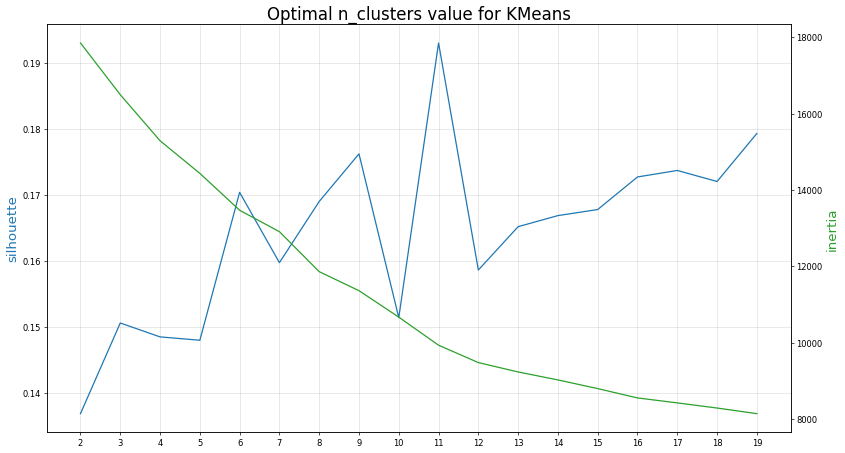

In [13]:
#KMeans - нахождение оптимального числа кластеров с использованием Elbow method и Silhouette plot

inertia_km = []
silhouette_km = []
k_km  = range(2, 20)

for k_i in k_km:
    km = KMeans(n_clusters=k_i)
    km.fit(data_sc)
    inertia_km.append(km.inertia_)
    silhouette_km.append(silhouette_score(data_sc, km.labels_))

    
fig, ax1 = plt.subplots(1,1,figsize=(16,9), dpi= 60)
ax1.plot(k_km, silhouette_km, color='tab:blue')

ax2 = ax1.twinx()
ax2.plot(k_km, inertia_km, color='tab:green')

ax1.set_ylabel('silhouette', color='tab:blue', fontsize=16)
ax1.set_title("Optimal n_clusters value for KMeans", fontsize=20)
ax1.set_xticks(np.arange(k_km[0], k_km[0]+len(k_km), 1))
ax1.grid(alpha=.4)

ax2.set_xlabel('k', fontsize=16)
ax2.set_ylabel('inertia', color='tab:green', fontsize=16)

plt.show()    

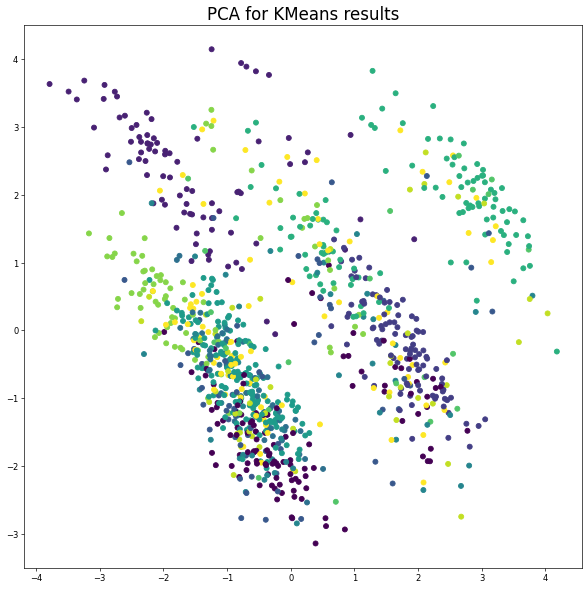

In [14]:
#визуализация результатов кластеризации оптимизированной модели KMeans в сжатом признаковом пространстве PCA

km = KMeans(n_clusters=12)
km.fit(data_sc)

plt.figure(figsize=(12, 12), dpi= 60)
plt.title("PCA for KMeans results", fontsize=20)
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=km.labels_)

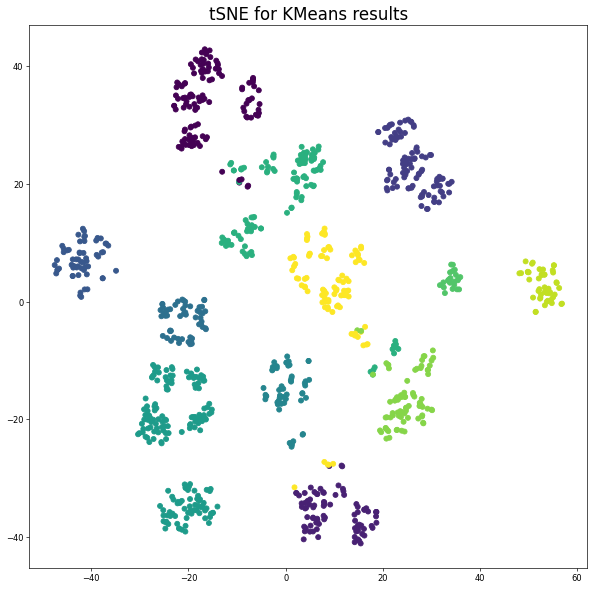

In [15]:
#визуализация результатов кластеризации оптимизированной модели KMeans в сжатом признаковом пространстве tSNE

plt.figure(figsize=(12, 12), dpi= 60)
plt.title("tSNE for KMeans results", fontsize=20)
plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=km.labels_)

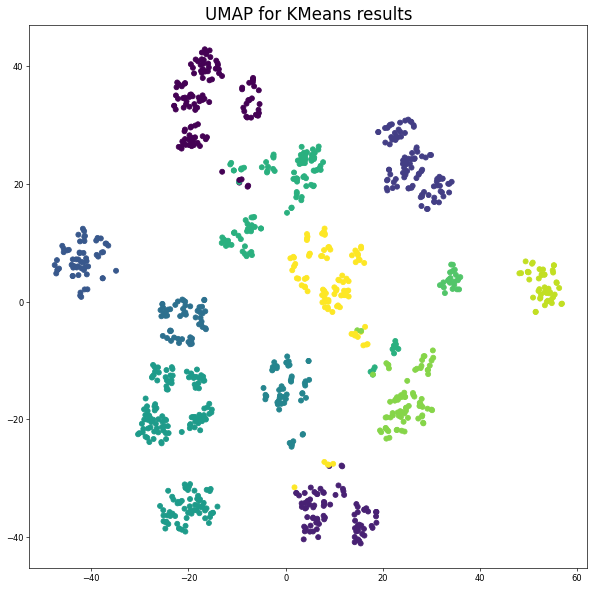

In [16]:
#визуализация результатов кластеризации оптимизированной модели KMeans в сжатом признаковом пространстве UMAP

plt.figure(figsize=(12, 12), dpi= 60)
plt.title("UMAP for KMeans results", fontsize=20)
plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=km.labels_)

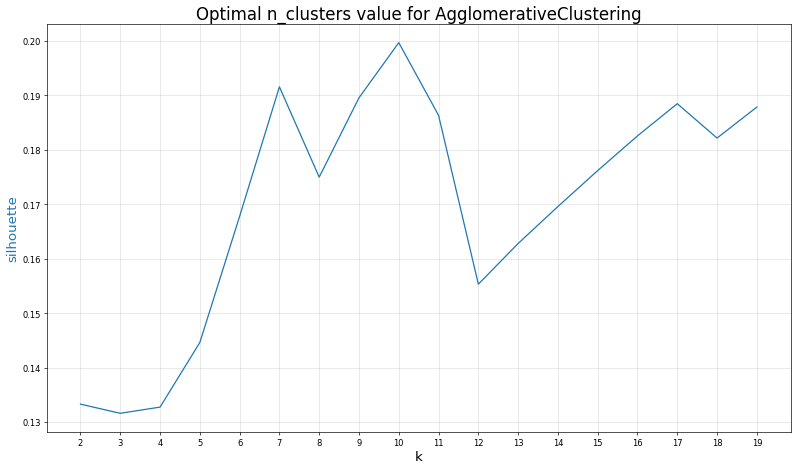

In [17]:
#AgglomerativeClustering - нахождение оптимального числа кластеров с использованием Silhouette plot

silhouette_agl = []
k_agl  = range(2, 20)

for k_i in k_agl:
    agl = AgglomerativeClustering(n_clusters=k_i)
    agl.fit(data_sc)
    silhouette_agl.append(silhouette_score(data_sc, agl.labels_))

    
fig, ax = plt.subplots(1,1,figsize=(16,9), dpi= 60)
ax.plot(k_agl, silhouette_agl, color='tab:blue')

ax.set_xlabel('k', fontsize=16)
ax.set_ylabel('silhouette', color='tab:blue', fontsize=16)
ax.grid(alpha=.4)

ax.set_title("Optimal n_clusters value for AgglomerativeClustering", fontsize=20)
ax.set_xticks(np.arange(k_agl[0], k_agl[0]+len(k_agl), 1))

plt.show() 

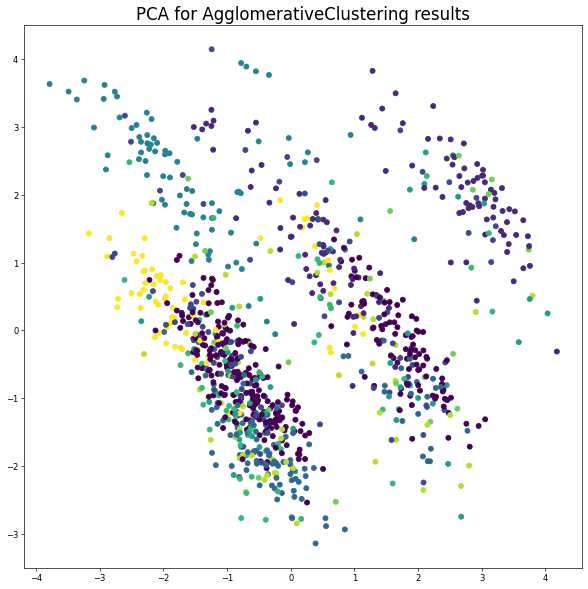

In [18]:
#визуализация результатов кластеризации оптимизированной модели AgglomerativeClustering в сжатом признаковом пространстве PCA

agl = AgglomerativeClustering(n_clusters=10)
agl.fit(data_sc)

plt.figure(figsize=(12, 12), dpi= 60)
plt.title("PCA for AgglomerativeClustering results", fontsize=20)
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=agl.labels_)

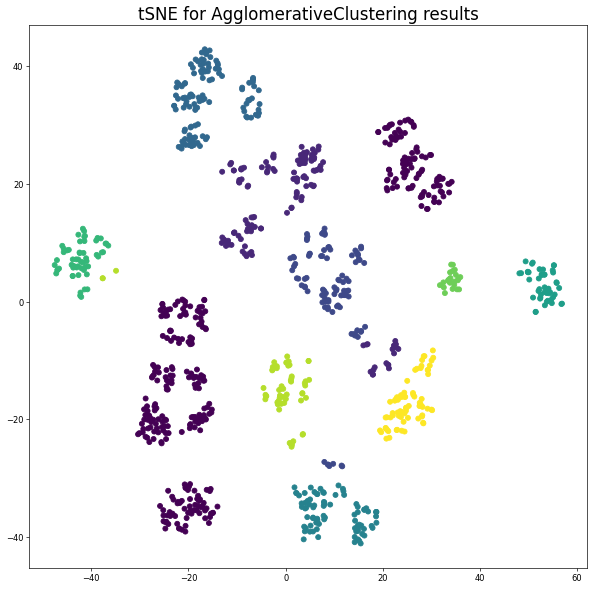

In [19]:
#визуализация результатов кластеризации оптимизированной модели AgglomerativeClustering в сжатом признаковом пространстве tSNE

plt.figure(figsize=(12, 12), dpi= 60)
plt.title("tSNE for AgglomerativeClustering results", fontsize=20)
plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=agl.labels_)

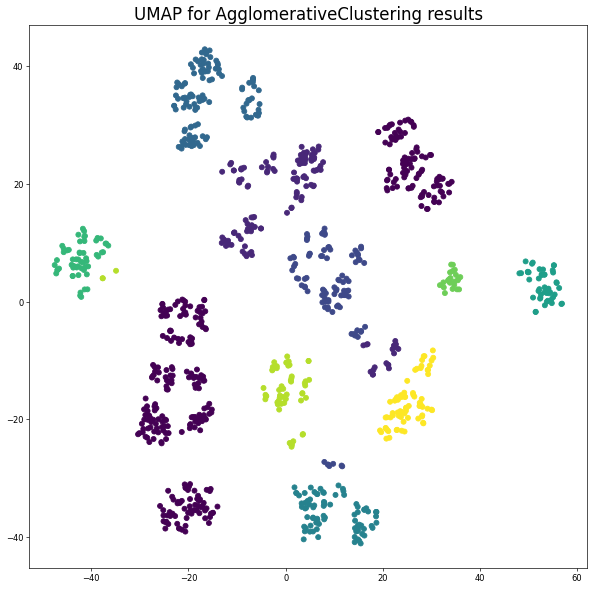

In [20]:
#визуализация результатов кластеризации оптимизированной модели AgglomerativeClustering в сжатом признаковом пространстве UMAP

plt.figure(figsize=(12, 12), dpi= 60)
plt.title("UMAP for AgglomerativeClustering results", fontsize=20)
plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=agl.labels_)

In [66]:
#DBSCAN - нахождение оптимального значения eps с использованием Silhouette plot

db_metrics = pd.DataFrame(columns = ['eps', 'min_samples', 'n_clusters', 'n_noise', 'silhouette_k'])
db_metrics_index = 0

eps_db = [0.1, 0.2, 0.4, 0.6, 0.8, 1., 1.2]
min_samples_db = [5, 50, 100, 250, 500, 1000]

for ms_i in min_samples_db:
    for eps_j in eps_db:
        db = DBSCAN(eps=eps_j, min_samples=ms_i)
        db.fit(data_sc)
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True        
        
        labels_db = db.labels_
        n_clusters_db = len(set(labels_db)) - (1 if -1 in labels_db else 0)
        n_noise_db = list(labels_db).count(-1)

        if n_clusters_db ==0:
            silhouette_k = 0
        else:
            silhouette_k = silhouette_score(data_sc, labels_db)
        
        db_metrics_row = [eps_j, ms_i, n_clusters_db, n_noise_db, silhouette_k]
        db_metrics.loc[db_metrics_index] = db_metrics_row   
        db_metrics_index += 1
        
db_metrics        


,eps,min_samples,n_clusters,n_noise,silhouette_k
0,0.1,5.0,0.0,1000.0,0.000000
1,0.2,5.0,0.0,1000.0,0.000000
2,0.4,5.0,0.0,1000.0,0.000000
3,0.6,5.0,1.0,995.0,-0.217527
4,0.8,5.0,8.0,911.0,-0.247006
5,1.0,5.0,19.0,818.0,-0.235891
6,1.2,5.0,25.0,721.0,-0.180419
7,0.1,50.0,0.0,1000.0,0.000000
8,0.2,50.0,0.0,1000.0,0.000000
9,0.4,50.0,0.0,1000.0,0.000000


In [ ]:
#построение оптимизированной модели DBSCAN

db = DBSCAN(eps=2, min_samples=10)
db.fit(data_sc)

labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

In [ ]:
#визуализация результатов кластеризации оптимизированной модели DBSCAN в сжатом признаковом пространстве PCA

plt.figure(figsize=(12, 12), dpi= 60)
plt.title("PCA for DBSCAN results", fontsize=20)
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=db.labels_)

In [ ]:
#визуализация результатов кластеризации оптимизированной модели DBSCAN в сжатом признаковом пространстве tSNE

plt.figure(figsize=(12, 12), dpi= 60)
plt.title("tSNE for DBSCAN results", fontsize=20)
plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=db.labels_)

In [ ]:
#визуализация результатов кластеризации оптимизированной модели DBSCAN в сжатом признаковом пространстве UMAP

plt.figure(figsize=(12, 12), dpi= 60)
plt.title("UMAP for DBSCAN results", fontsize=20)
plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=db.labels_)